In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important; }</style>"))

In [2]:
import warnings
warnings.simplefilter(action='ignore')

In [3]:
import seaborn as sns
import matplotlib.mlab as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker

def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=False):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "in",
                 "ytick.direction": "in"})
    rcparams = {'text.usetex': usetex,
              'font.family': 'sans-serif',
              'font.sans-serif': ['Helvetica'],
             # 'text.latex.unicode': True,
              'text.latex.preamble': [r"\usepackage[T1]{fontenc}",
                                      r"\usepackage{lmodern}",
                                      r"\usepackage{amsmath}",
                                      r"\usepackage{mathptmx}"
                                      ],
              'axes.labelsize': 30,
              'axes.titlesize': 30,
              'ytick.right': 'on',
              'xtick.top': 'on',
              'xtick.labelsize': '25',
              'ytick.labelsize': '25',
              'axes.linewidth': 1.8,
              'xtick.major.width': 1.8,
              'xtick.minor.width': 1.8,
              'xtick.major.size': 14,
              'xtick.minor.size': 7,
              'xtick.major.pad': 10,
              'xtick.minor.pad': 10,
              'ytick.major.width': 1.8,
              'ytick.minor.width': 1.8,
              'ytick.major.size': 14,
              'ytick.minor.size': 7,
              'ytick.major.pad': 10,
              'ytick.minor.pad': 10,
              'axes.labelpad': 15,
              'axes.titlepad': 15,
              "xtick.direction": "in",
              "ytick.direction": "in",
              'legend.fontsize': 20}
    mpl.rcParams.update(rcparams) 

mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['lines.color'] = '#3690c0'

stdrcparams(usetex=True)
figsize=stdfigsize(ratio=-1)
xs,ys=figsize

def custom_frame(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.tick_params(axis='x',length=10,direction='out')
    ax.tick_params(axis='x',which='minor',direction='out')
    ax.tick_params(axis='y',length=10,direction='out')
    ax.tick_params(axis='y',which='minor',direction='out')

In [5]:
import pickle
import itertools
import math
import random
import pandas as pd
import numpy as np
import networkx as nx

from datetime import date

In [6]:
df_air = pd.read_pickle('../results/networks/US_air_2004_2021_dl.pkl')
df_air = df_air[df_air.source != df_air.target]
df_air = df_air.reset_index()
df_air = df_air[df_air.YEAR>=2004].set_index(['YEAR','MONTH'])
year = list(df_air.index.get_level_values(0).unique())
month = list(df_air.index.get_level_values(1).unique())
graphs_air = []
date_air = []
for y in year:
    for m in month:
        try:
            df = df_air.loc[y,m]
            date_air.append(date(y,m,1))
            G = nx.from_pandas_edgelist(df_air.loc[y,m], edge_attr=True)
            graphs_air.append(G)
        except:
            pass
del df_air

In [7]:
data = pd.read_pickle('../results/us_air_data_binary_removal_dl.pkl').replace([np.inf, -np.inf], np.nan).dropna(how='all')
data = data[data.year>=date(2004,1,1)]
rename_dict = {}
for column in data.columns:
    if '_index' in column:
        column_v = column.replace('_index','',1)
    else:
        column_v =  column
    rename_dict[column]=column_v.replace('_',' ',3).title()
    
rename_again = {'Common Neighbor' : 'CN', 'Salton':'SA' , 'Jaccard':'JA', 'Sorensen':'SO', 'Hub Promoted':'HPI',
       'Hub Depressed':'HDI', 'Leicht Holme Newman':'LHNI', 'Preferential Attachment':'PA',
       'Adamic Adar':'AA', 'Resource Allocation':'RA', 'Local Path':'LP'}
    
data_air = data.rename(columns=rename_dict).rename(columns={'Prederential Attachment':'Preferential Attachment'})

columns=['Common Neighbor', 'Salton', 'Jaccard', 'Sorensen', 'Hub Promoted',
       'Hub Depressed', 'Leicht Holme Newman', 'Preferential Attachment',
       'Adamic Adar', 'Resource Allocation', 'Local Path',
        'Year','Edge','Time','Label']

data_air =  data_air[columns].rename(columns=rename_again)

In [ ]:
# import essential packages
import cartopy.crs as ccrs
import cartopy as cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
from cartopy.io import shapereader
from matplotlib.lines import Line2D

In [9]:
#function to convert node name to readable form
def make_node_name(node):
    node = node.title()
    text = node.split('_')    
    if len(text)<3:
        return ','.join([text[0],text[1].upper()])
    else:
        city = ' '.join(text[0:-1])
        state = text[-1]
        state = state.upper()
        return ','.join([city,state])


#nodes position information
def plot_air_network(facecolor='#f0f0f0'):
    pos = pd.read_pickle('../data/US_air_geo_information.pkl')

    #prepare labels for edges
    labels = ['Retained Edge', 'Removed Edge'] # this order is fixed
    colors = ['black', 'red']
    styles = ['solid', 'dashed']
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle= s) for c,s in zip(colors,styles)]

    #select snapshot for displaying 
    year = date(2014,1,1)
    G = graphs_air[date_air.index(year)]
    H = graphs_air[date_air.index(year) + 1]

    #edges separation
    ## the edges that are in mainland us
    edges_in_land = [edge for edge in G.edges() if (pos[edge[0]].lng >= -128 and pos[edge[0]].lng <= -65 and pos[edge[1]].lng >= -128 and pos[edge[1]].lng <=-65)]
    edges_in_land = [edge for edge in edges_in_land if (pos[edge[0]].lat >= 23 and pos[edge[1]].lat >= 23)]


    # border = [-125,-67,25,50] # xmin_xmax_ymin_ymax
    border = [-119,-74,23,50]
    central_lon = np.mean(border[:2])
    central_lat = np.mean(border[2:])


    fig = plt.figure(figsize=(xs,ys),frameon=False)
    ax = fig.add_subplot(1,1,1,projection=ccrs.AlbersEqualArea(central_lon, central_lat))

    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='110m',
                                         category='cultural', name=shapename)
    shp = shapereader.Reader(states_shp)
    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)
    for record, state in zip(shp.records(), shp.geometries()):
        name = record.attributes['name']
        facecolor = facecolor #'#faf2dd' #'#f0f0f0'
        ax.add_geometries([state], ccrs.PlateCarree(),
                          facecolor=facecolor, edgecolor='none',zorder=-1)
    ax.set_extent(border)
    # ax.set_xlim(-125,-67)
    # ax.set_ylim(20,50)
    # draw edges
    draw(G,
            pos = pos,
            width= 0.1,
            alpha= 0.15,
            node_size = 0,
            edgelist= edges_in_land,
            edge_color = 'black',
            style = 'solid',ax=ax)

    # draw nodes
    draw(G,
            pos = pos,
            node_color = '#377eb8',
            width= 0,
            alpha= 1,
            node_size = np.array(list(dict(G.degree()).values()))/0.5)

    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)
    ax.set_title('US Air - DL (Jan. 2014)')
    plt.savefig(f'../figures/Fig.1B_DL.png',bbox_inches='tight',dpi=200,transparent=True)
    plt.show()

In [11]:
import warnings
warnings.simplefilter(action='ignore')

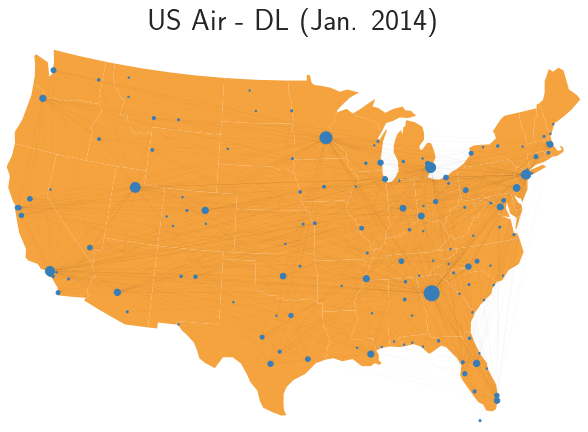

In [74]:
plot_air_network(facecolor='#f5a33e')

In [4]:
from numbers import Number
import networkx as nx
from networkx.utils import is_string_like
from networkx.drawing.layout import shell_layout, \
    circular_layout, kamada_kawai_layout, spectral_layout, \
    spring_layout, random_layout, planar_layout

__all__ = ['draw',
           'draw_networkx',
           'draw_networkx_nodes',
           'draw_networkx_edges',
           'draw_networkx_labels',
           'draw_networkx_edge_labels',
           'draw_circular',
           'draw_kamada_kawai',
           'draw_random',
           'draw_spectral',
           'draw_spring',
           'draw_planar',
           'draw_shell']


def draw(G, pos=None, ax=None, **kwds):

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        raise ImportError("Matplotlib required for draw()")
    except RuntimeError:
        print("Matplotlib unable to open display")
        raise

    if ax is None:
        cf = plt.gcf()
    else:
        cf = ax.get_figure()
    cf.set_facecolor('w')
    if ax is None:
        if cf._axstack() is None:
            ax = cf.add_axes((0, 0, 1, 1))
        else:
            ax = cf.gca()

    if 'with_labels' not in kwds:
        kwds['with_labels'] = 'labels' in kwds

    draw_networkx(G, pos=pos, ax=ax, **kwds)
    ax.set_axis_off()
    plt.draw_if_interactive()
    return



def draw_networkx(G, pos=None, arrows=True, with_labels=True, **kwds):

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        raise ImportError("Matplotlib required for draw()")
    except RuntimeError:
        print("Matplotlib unable to open display")
        raise

    if pos is None:
        pos = nx.drawing.spring_layout(G)  # default to spring layout

    node_collection = draw_networkx_nodes(G, pos, **kwds)
    edge_collection = draw_networkx_edges(G, pos, arrows=arrows, **kwds)
    if with_labels:
        draw_networkx_labels(G, pos, **kwds)
    plt.draw_if_interactive()



def draw_networkx_nodes(G, pos,
                        nodelist=None,
                        node_size=300,
                        node_color='#1f78b4',
                        node_shape='o',
                        alpha=None,
                        cmap=None,
                        vmin=None,
                        vmax=None,
                        ax=None,
                        linewidths=None,
                        edgecolors=None,
                        label=None,
                        **kwds):

    from collections.abc import Iterable
    try:
        import matplotlib.pyplot as plt
        import numpy as np
    except ImportError:
        raise ImportError("Matplotlib required for draw()")
    except RuntimeError:
        print("Matplotlib unable to open display")
        raise

    if ax is None:
        ax = plt.gca()

    if nodelist is None:
        nodelist = list(G)

    if len(nodelist) == 0:  # empty nodelist, no drawing
        return

    try:
        xy = np.asarray([pos[v] for v in nodelist])
    except KeyError as e:
        raise nx.NetworkXError('Node %s has no position.' % e)
    except ValueError:
        raise nx.NetworkXError('Bad value in node positions.')

    if isinstance(alpha, Iterable):
        node_color = apply_alpha(node_color, alpha, nodelist, cmap, vmin, vmax)
        alpha = None

    node_collection = ax.scatter(xy[:, 0], xy[:, 1],
                                 s=node_size,
                                 c=node_color,
                                 marker=node_shape,
                                 cmap=cmap,
                                 vmin=vmin,
                                 vmax=vmax,
                                 alpha=alpha,
                                 linewidths=linewidths,
                                 edgecolors=edgecolors,
                                 label=label,transform=ccrs.Geodetic())
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)

    node_collection.set_zorder(2)
    return node_collection



def draw_networkx_edges(G, pos,
                        edgelist=None,
                        width=1.0,
                        edge_color='k',
                        style='solid',
                        alpha=None,
                        arrowstyle='-|>',
                        arrowsize=10,
                        edge_cmap=None,
                        edge_vmin=None,
                        edge_vmax=None,
                        ax=None,
                        arrows=True,
                        label=None,
                        node_size=300,
                        nodelist=None,
                        node_shape="o",
                        connectionstyle=None,
                        min_source_margin=0,
                        min_target_margin=0,
                        **kwds):
    try:
        import matplotlib
        import matplotlib.pyplot as plt
        from matplotlib.colors import colorConverter, Colormap, Normalize
        from matplotlib.collections import LineCollection
        from matplotlib.patches import FancyArrowPatch
        import numpy as np
    except ImportError:
        raise ImportError("Matplotlib required for draw()")
    except RuntimeError:
        print("Matplotlib unable to open display")
        raise

    if ax is None:
        ax = plt.gca()

    if edgelist is None:
        edgelist = list(G.edges())

    if not edgelist or len(edgelist) == 0:  # no edges!
        return None

    if nodelist is None:
        nodelist = list(G.nodes())

    # FancyArrowPatch handles color=None different from LineCollection
    if edge_color is None:
        edge_color = 'k'

    # set edge positions
    edge_pos = np.asarray([(pos[e[0]], pos[e[1]]) for e in edgelist])

    # Check if edge_color is an array of floats and map to edge_cmap.
    # This is the only case handled differently from matplotlib
    if np.iterable(edge_color) and (len(edge_color) == len(edge_pos)) \
            and np.alltrue([isinstance(c, Number) for c in edge_color]):
        if edge_cmap is not None:
            assert(isinstance(edge_cmap, Colormap))
        else:
            edge_cmap = plt.get_cmap()
        if edge_vmin is None:
            edge_vmin = min(edge_color)
        if edge_vmax is None:
            edge_vmax = max(edge_color)
        color_normal = Normalize(vmin=edge_vmin, vmax=edge_vmax)
        edge_color = [edge_cmap(color_normal(e)) for e in edge_color]

    if (not G.is_directed() or not arrows):
        edge_collection = LineCollection(edge_pos,
                                         colors=edge_color,
                                         linewidths=width,
                                         antialiaseds=(1,),
                                         linestyle=style,
                                         transOffset=ax.transData,
                                         alpha=alpha,transform=ccrs.Geodetic()
                                         )

        edge_collection.set_zorder(1)  # edges go behind nodes
        edge_collection.set_label(label)
        ax.add_collection(edge_collection)

        return edge_collection

    arrow_collection = None

    if G.is_directed() and arrows:
        # Note: Waiting for someone to implement arrow to intersection with
        # marker.  Meanwhile, this works well for polygons with more than 4
        # sides and circle.

        def to_marker_edge(marker_size, marker):
            if marker in "s^>v<d":  # `large` markers need extra space
                return np.sqrt(2 * marker_size) / 2
            else:
                return np.sqrt(marker_size) / 2

        # Draw arrows with `matplotlib.patches.FancyarrowPatch`
        arrow_collection = []
        mutation_scale = arrowsize  # scale factor of arrow head

        # FancyArrowPatch doesn't handle color strings
        arrow_colors = colorConverter.to_rgba_array(edge_color, alpha)
        for i, (src, dst) in enumerate(edge_pos):
            x1, y1 = src
            x2, y2 = dst
            shrink_source = 0  # space from source to tail
            shrink_target = 0  # space from  head to target
            if np.iterable(node_size):  # many node sizes
                src_node, dst_node = edgelist[i][:2]
                index_node = nodelist.index(dst_node)
                marker_size = node_size[index_node]
                shrink_target = to_marker_edge(marker_size, node_shape)
            else:
                shrink_target = to_marker_edge(node_size, node_shape)

            if shrink_source < min_source_margin:
                shrink_source = min_source_margin

            if shrink_target < min_target_margin:
                shrink_target = min_target_margin

            if len(arrow_colors) == len(edge_pos):
                arrow_color = arrow_colors[i]
            elif len(arrow_colors) == 1:
                arrow_color = arrow_colors[0]
            else:  # Cycle through colors
                arrow_color = arrow_colors[i % len(arrow_colors)]

            if np.iterable(width):
                if len(width) == len(edge_pos):
                    line_width = width[i]
                else:
                    line_width = width[i % len(width)]
            else:
                line_width = width

            arrow = FancyArrowPatch((x1, y1), (x2, y2),
                                    arrowstyle=arrowstyle,
                                    shrinkA=shrink_source,
                                    shrinkB=shrink_target,
                                    mutation_scale=mutation_scale,
                                    color=arrow_color,
                                    linewidth=line_width,
                                    connectionstyle=connectionstyle,
                                    zorder=1)  # arrows go behind nodes

            # There seems to be a bug in matplotlib to make collections of
            # FancyArrowPatch instances. Until fixed, the patches are added
            # individually to the axes instance.
            arrow_collection.append(arrow)
            ax.add_patch(arrow)

    # update view
    minx = np.amin(np.ravel(edge_pos[:, :, 0]))
    maxx = np.amax(np.ravel(edge_pos[:, :, 0]))
    miny = np.amin(np.ravel(edge_pos[:, :, 1]))
    maxy = np.amax(np.ravel(edge_pos[:, :, 1]))

    w = maxx - minx
    h = maxy - miny
    padx,  pady = 0.05 * w, 0.05 * h
    corners = (minx - padx, miny - pady), (maxx + padx, maxy + pady)
    ax.update_datalim(corners)
    ax.autoscale_view()

    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)

    return arrow_collection



def draw_networkx_labels(G, pos,
                         labels=None,
                         font_size=12,
                         font_color='k',
                         font_family='sans-serif',
                         font_weight='normal',
                         alpha=None,
                         bbox=None,
                         ax=None,
                         **kwds):

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        raise ImportError("Matplotlib required for draw()")
    except RuntimeError:
        print("Matplotlib unable to open display")
        raise

    if ax is None:
        ax = plt.gca()

    if labels is None:
        labels = dict((n, n) for n in G.nodes())

    # set optional alignment
    horizontalalignment = kwds.get('horizontalalignment', 'center')
    verticalalignment = kwds.get('verticalalignment', 'center')

    text_items = {}  # there is no text collection so we'll fake one
    for n, label in labels.items():
        (x, y) = pos[n]
        if not is_string_like(label):
            label = str(label)  # this makes "1" and 1 labeled the same
        t = ax.text(x, y,
                    label,
                    size=font_size,
                    color=font_color,
                    family=font_family,
                    weight=font_weight,
                    alpha=alpha,
                    horizontalalignment=horizontalalignment,
                    verticalalignment=verticalalignment,
                    transform=ax.transData,
                    bbox=bbox,
                    clip_on=True,
                    )
        text_items[n] = t

    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)

    return text_items



def draw_networkx_edge_labels(G, pos,
                              edge_labels=None,
                              label_pos=0.5,
                              font_size=10,
                              font_color='k',
                              font_family='sans-serif',
                              font_weight='normal',
                              alpha=None,
                              bbox=None,
                              ax=None,
                              rotate=True,
                              **kwds):
  
    try:
        import matplotlib.pyplot as plt
        import numpy as np
    except ImportError:
        raise ImportError("Matplotlib required for draw()")
    except RuntimeError:
        print("Matplotlib unable to open display")
        raise

    if ax is None:
        ax = plt.gca()
    if edge_labels is None:
        labels = {(u, v): d for u, v, d in G.edges(data=True)}
    else:
        labels = edge_labels
    text_items = {}
    for (n1, n2), label in labels.items():
        (x1, y1) = pos[n1]
        (x2, y2) = pos[n2]
        (x, y) = (x1 * label_pos + x2 * (1.0 - label_pos),
                  y1 * label_pos + y2 * (1.0 - label_pos))

        if rotate:
            # in degrees
            angle = np.arctan2(y2 - y1, x2 - x1) / (2.0 * np.pi) * 360
            # make label orientation "right-side-up"
            if angle > 90:
                angle -= 180
            if angle < - 90:
                angle += 180
            # transform data coordinate angle to screen coordinate angle
            xy = np.array((x, y))
            trans_angle = ax.transData.transform_angles(np.array((angle,)),
                                                        xy.reshape((1, 2)))[0]
        else:
            trans_angle = 0.0
        # use default box of white with white border
        if bbox is None:
            bbox = dict(boxstyle='round',
                        ec=(1.0, 1.0, 1.0),
                        fc=(1.0, 1.0, 1.0),
                        )
        if not is_string_like(label):
            label = str(label)  # this makes "1" and 1 labeled the same

        # set optional alignment
        horizontalalignment = kwds.get('horizontalalignment', 'center')
        verticalalignment = kwds.get('verticalalignment', 'center')

        t = ax.text(x, y,
                    label,
                    size=font_size,
                    color=font_color,
                    family=font_family,
                    weight=font_weight,
                    alpha=alpha,
                    horizontalalignment=horizontalalignment,
                    verticalalignment=verticalalignment,
                    rotation=trans_angle,
                    transform=ax.transData,
                    bbox=bbox,
                    zorder=1,
                    clip_on=True,
                    )
        text_items[(n1, n2)] = t

    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)

    return text_items